## Electron Localization in Molecules and Solids

Localization and delocalization are two concepts widely used in chemistry. For example, molecular CF4 or solid ZnS (sphalerite) are often considered to be linked by localized bonds, and pictured via Lewis structures. However, molecular SF6 and rocksalt form of ZnS can not be depicted by Lewis structures as “delocalized” bonds are involved. Delocalized bonding over more
than two atomic centers is found in many systems, including a large class of aromitic molecules. Metals are often envisioned as containing electrons delocalized throughout the solid but insulators as containing localized electrons.

To understand electron localization, the electron localization function (ELF) is defined as:

$$\mathrm{ELF} = \left[{1 + \left(\frac{P}{P_\mathrm{gas}}\right)^2}\right]^{-1}$$

where $P$ is the spin pair probability, and $P_\mathrm{gas}$ is the corresponding value for the homogeneous electron gas, i.e. the fully-delocalized state.

ELF of 1.0 corresponds to perfect localization and ELF of 0.5 to perfect delocalizaton. 

In [11]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

import scipy.special as ss
import numpy as np
import math
import copy

In [12]:
#Package for plotting Cube files
### import numpy as np
#from math import ceil, floor, sqrt
 
class Cube:
    def __init__(self, fname):
        f = open(fname, 'r')
        for i in range(2): 
            f.readline()
        tkns = f.readline().split() # number of atoms included in the file followed by the
        #position of the origin of the volumetric data
        self.natoms = int(float(tkns[0]))
        self.origin = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    # The next three lines give the number of voxels along each axis (x, y, z) followed by the axis vector.
        tkns = f.readline().split() #
        self.NX = int(tkns[0])
        self.X = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
        tkns = f.readline().split() #
        self.NY = int(tkns[0])
        self.Y = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
        tkns = f.readline().split() #
        self.NZ = int(tkns[0])
        self.Z = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    # For cube cells with axes perpendicular to each other
        self.dx = self.X[0]
        self.x_lim = self.dx*self.NX
        self.dy = self.Y[1]
        self.y_lim = self.dy*self.NY
        self.dz = self.Z[2]
        self.z_lim = self.dz*self.NZ
        self.voxel = self.dx*self.dy*self.dz
    # The last section in the header is one line for each atom consisting of 
    #5 numbers, the first is the atom number, second (?), the last three are the x,y,z coordinates of the atom center. 
        self.atoms = []
        self.cd_z={}
        self.cd_znorm={}
        for i in range(self.natoms):
            tkns = f.readline().split()
            x, y, z = float(tkns[2])%self.x_lim, float(tkns[3])%self.y_lim, float(tkns[4])%self.z_lim
            self.atoms.append([int(float(tkns[0])), x, y, z])
            chg = abs(int(float(tkns[0])) - 2)
            
            #Bin size according to voxel
            z_coord_vox=round(float(tkns[4])/self.dz, 0)*self.dz
            if z_coord_vox in self.cd_znorm.keys():
                self.cd_znorm[z_coord_vox]+=chg/self.voxel
            else:
                self.cd_znorm[z_coord_vox]=chg/self.voxel
            #Fill with zeros not written voxels
            z_axis=np.arange(0, self.z_lim, self.dz)
            for point in z_axis:
                if point not in self.cd_znorm.keys():
                    self.cd_znorm[point]=0
            #Just coordinates and charges
            z_coord=float(tkns[4])
            if float(tkns[4]) in self.cd_z.keys():
                self.cd_z[float(tkns[4])]+=chg/self.voxel
            else:
                self.cd_z[float(tkns[4])]=chg/self.voxel

        self.atoms = np.array(self.atoms)
    # Volumetric data
        self.data = np.zeros((self.NX,self.NY,self.NZ))
        i=0
        for s in f:
            for v in s.split():
                self.data[i/(self.NY*self.NZ), (i/self.NZ)%self.NY, i%self.NZ] = float(v)
                i+=1
        if i != self.NX*self.NY*self.NZ:
            raise NameError, "FSCK!"
 

    def mask_sphere(self, R, Cx,Cy,Cz):
# produce spheric volume mask with radius R and center @ [Cx,Cy,Cz]
# can be used for integration over spherical part of the volume
        m=0*self.data
        for ix in xrange( int(ceil((Cx-R)/self.X[0])), int(floor((Cx+R)/self.X[0])) ):
            ryz=sqrt(R**2-(ix*self.X[0]-Cx)**2)
            for iy in xrange( int(ceil((Cy-ryz)/self.Y[1])), int(floor((Cy+ryz)/self.Y[1])) ):
                rz=sqrt(ryz**2 - (iy*self.Y[1]-Cy)**2)
                for iz in xrange( int(ceil((Cz-rz)/self.Z[2])), int(floor((Cz+rz)/self.Z[2])) ):
                    m[ix,iy,iz]=1
        return m
    
    def _gen_grid(self):
        """Return meshgrid with x, y, z"""
        return np.mgrid[0:self.x_lim:self.dx, 0:self.y_lim:self.dy, 0:self.z_lim:self.dz]
    
    def add_atom_charges(self):
        """Add atom charges to data. Assume that we have only 1st, 2nd row atoms.
        Time consuming."""
        # we had electrons, so first of all we need to change charge
        self.data = -self.data
        for chg, x_atom, y_atom, z_atom in self.atoms:
            # remove core electrons from 2nd row, but ignore H
            chg = abs(chg - 2) 
            # find atoms closest grid points
            x_idx = int(round(x_atom/self.dx))%self.NX
            y_idx = int(round(y_atom/self.dy))%self.NY
            z_idx = int(round(z_atom/self.dz))%self.NZ
            # add chg to data
            self.data[x_idx, y_idx, z_idx] += chg/self.voxel
        # finished looping
        
    def add_to_self(self, other):
        """Simply adds data"""
        assert self.NX == other.NX
        assert self.NY == other.NY
        assert self.NZ == other.NZ
        self.data += other.data

from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [17]:
def plot_cube(cube_file, Emin, Emax):
    cube = copy.deepcopy(cube_file)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    width = 10
    resol = 21

    [X1, Y1, Z1] = cube._gen_grid()
    norm = MidpointNormalize(midpoint=0)
    C = cube.data
    for i in range(len(C)):
        for j in range(len(C[i])):
            for k in range(len(C[i][j])):
                if C[i][j][k]<Emin or C[i][j][k]>Emax:
                    C[i][j][k]=0
    S = np.abs(C)*10

    ax.scatter(X1, Y1, Z1, c=C, s=S, cmap=cm.get_cmap('jet'), marker='h', linewidths=0, norm=norm)

    ax.view_init(elev=20, azim=60)

    plt.show()

In [14]:
h2o = Cube('h2o.cube')

In [5]:
c6h6 = Cube('c6h6.cube')

In [6]:
gr = Cube('gr.cube')

In [7]:
c = Cube('c.cube')

In [8]:
li = Cube('li.cube')

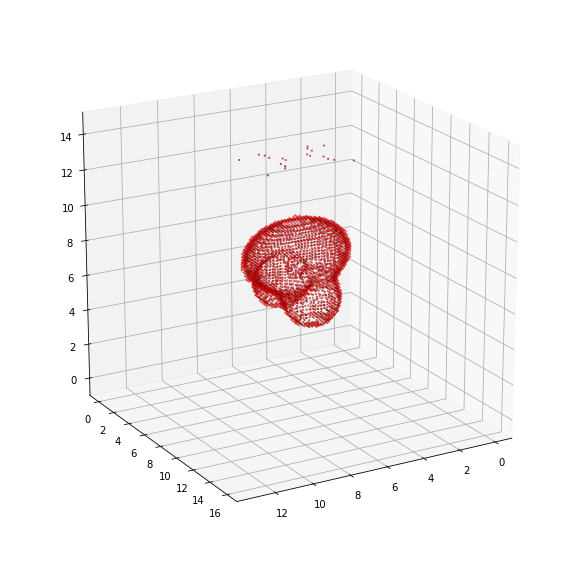

In [18]:
plot_cube(h2o, 0.5, 0.6)

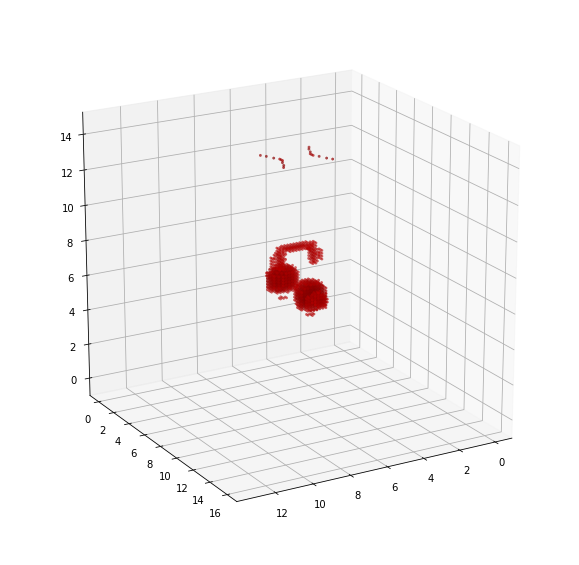

In [19]:
plot_cube(h2o, 0.9, 1.0)

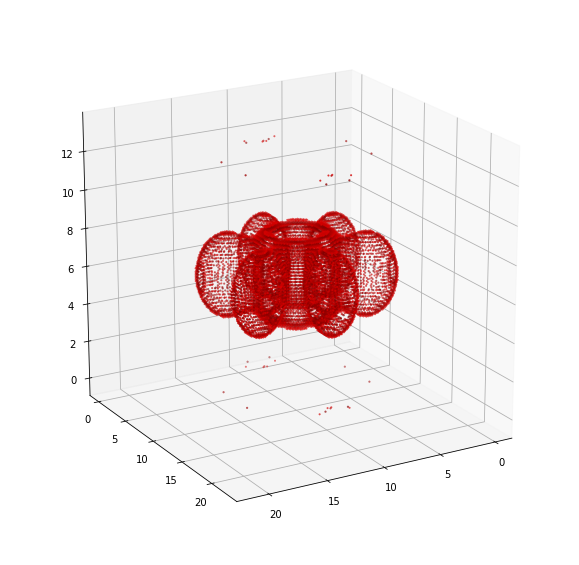

In [20]:
plot_cube(c6h6, 0.5, 0.6)

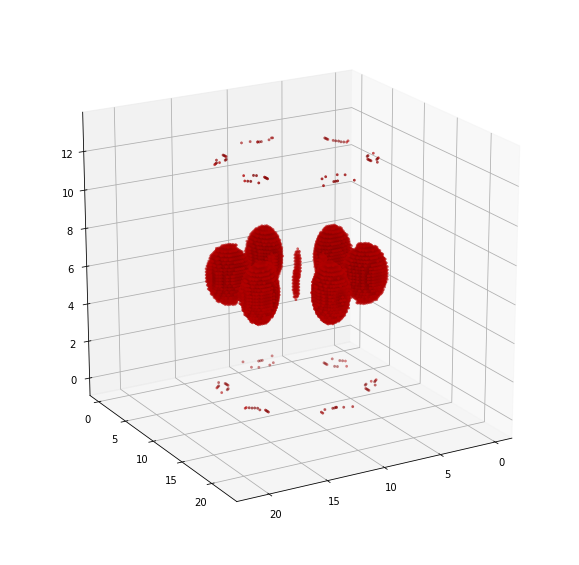

In [21]:
plot_cube(c6h6, 0.9, 1.0)

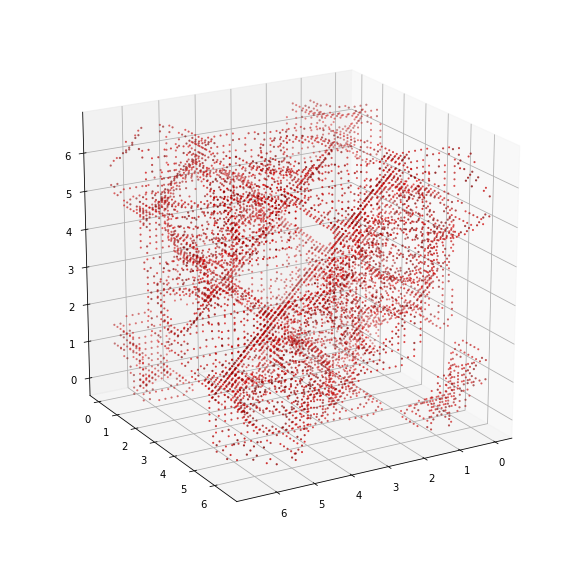

In [24]:
plot_cube(c, 0.5, 0.6)

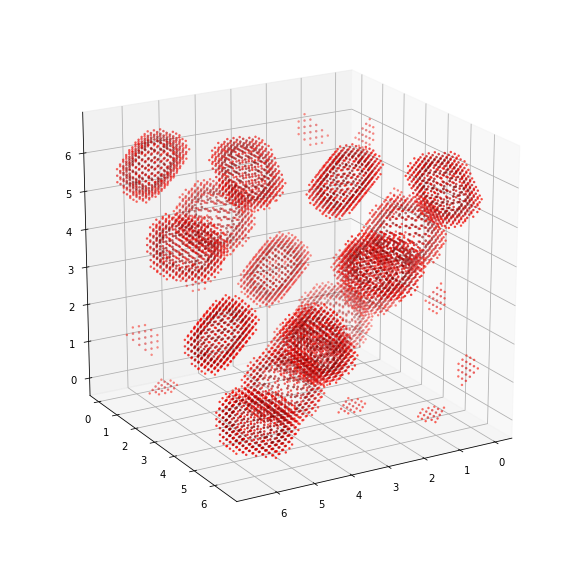

In [34]:
plot_cube(c, 0.7, 0.9)

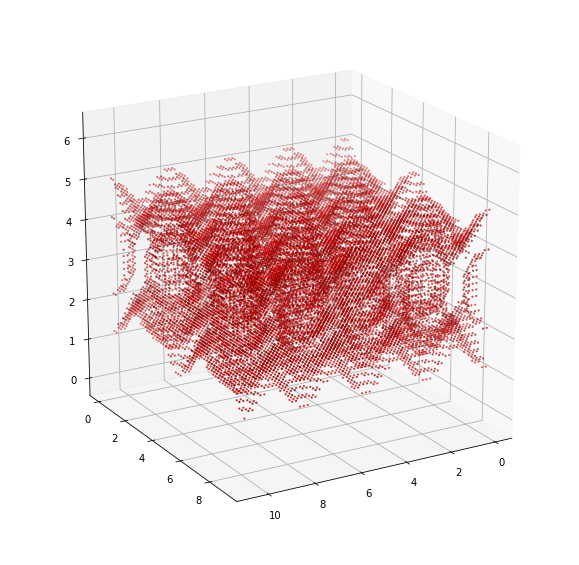

In [38]:
plot_cube(gr, 0.5, 0.6)

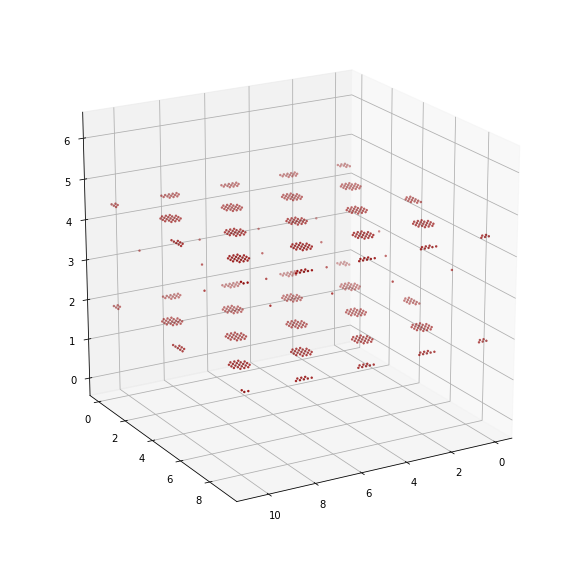

In [37]:
plot_cube(gr, 0.7, 0.9)

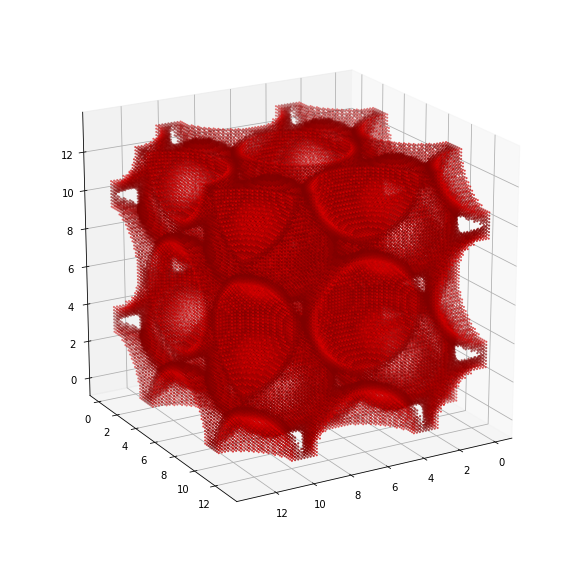

In [28]:
plot_cube(li, 0.5, 0.6)

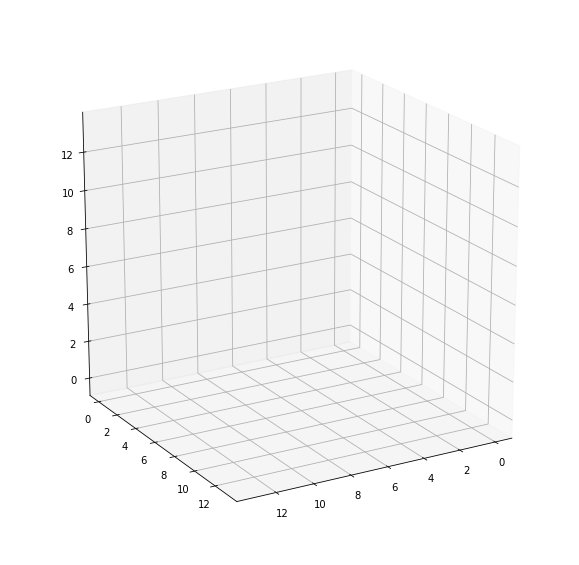

In [35]:
plot_cube(li, 0.7, 0.9)